## Leveling Up Complexity

As we complexify the neural networks and work all the way out to **transformers**, the approach of the Multilayer Perceptron won't really fundamentally change. 

The only thing that will change is the way we do the forward pass, where we take in some previous characters, and calculate 'logits' of the next character.

It's not obvious how we would extend the bigram approach of taking the previous character as context to infer the next one (if we use the same approach, the more chars we use as input, the way more combinations will have to be calculated -- it grows exponentially). **It's an unscallable approach.**

The Neural Network approach is significantly more scalable. 

### Bengio et al 2003

[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This paper (is not the first) proposes the approach of giving a representation of every word in a vocabulary, e.g. 17000 (we will be using characters instead) in a 30 dimension space (a very little space compared to the amount of points).

Initially, this points are initialized randomly. But then we are going to tune these embeddings using back propagation. 

During the course of training this NN, this points are going to move around in the space. Imagine that words with very similar meanings or synonymns end up in a very similar part of the space. The modeling approach is identical to ours, using negative log likelihood and multilayer neural network to predict the next token.

For example, sometimes you are trying to predict the next word in a context that is not in the training data set, let's say: 'A dog was running in a ...'. People in the field calls it to be 'out of distribution', you don't really have any reason to know what might come next. Well, **this approach allows you to get arround that**.

Because maybe you didn't have that phrase but you had 'The dog was running in a ...', and you learnt that 'The' and 'a' have similar meanings in this kind of contexts, i.e. they are near in the embedded space. It allows for generalization. 

### Model Explanation

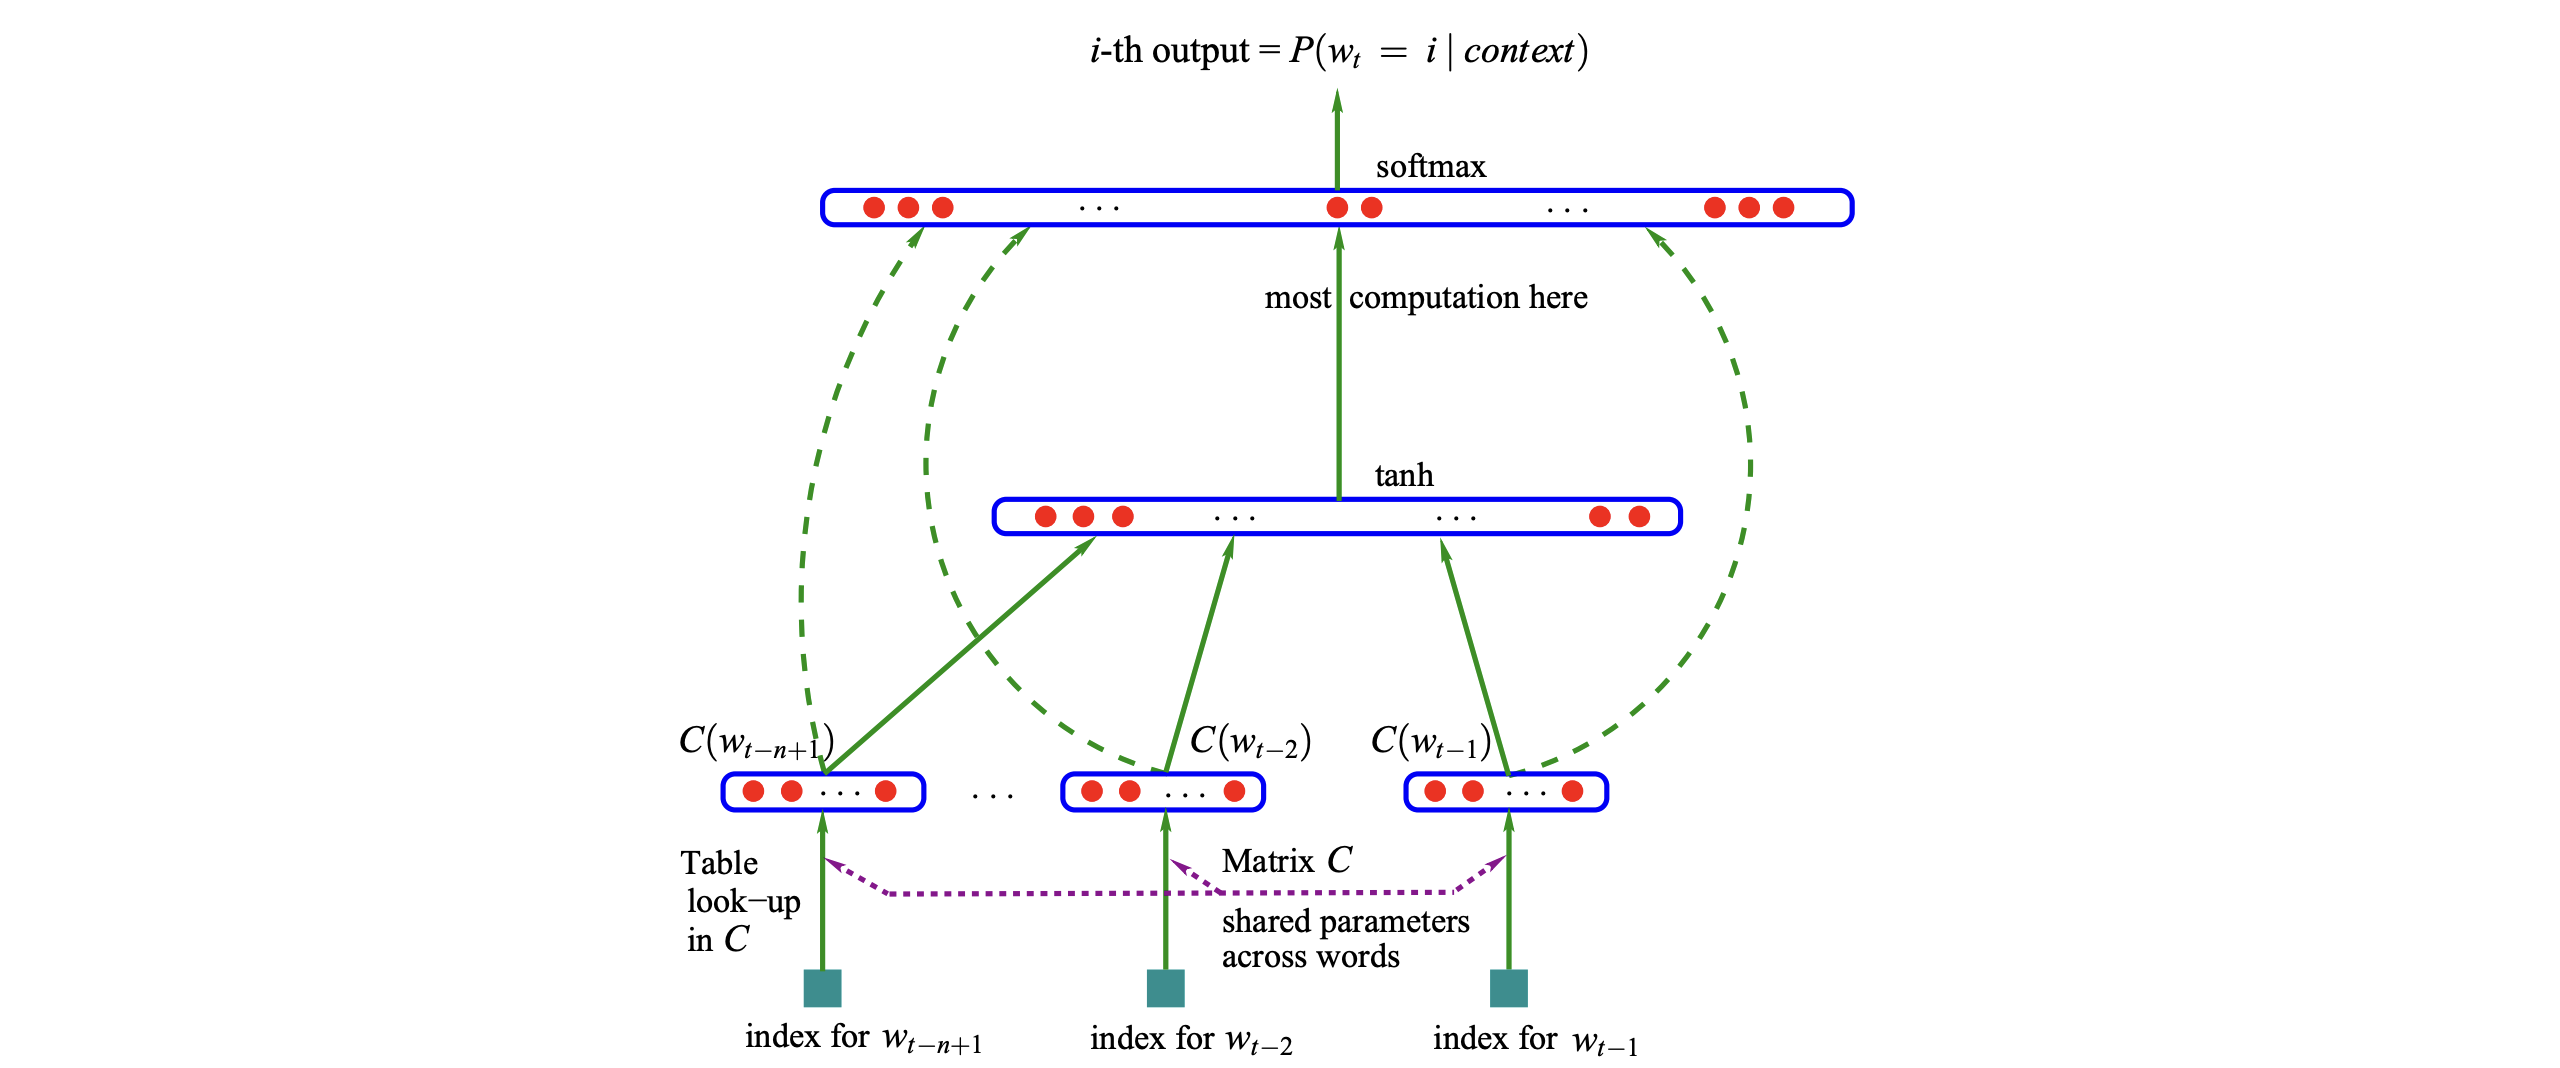

From bottom to top.

1. The models takes the last three words (or chars) as input context. Each word (or char) has an integer index (that could be hot-encoded in a vector of the length of the vocabulary (e.g. 17000), but won't because is not necesary).

2. As I explained before, we have a (firstly random) 30 dim embedding for each word. To calculate the embedding of each of the input words, we have a 30x17000 'C' matrix that returns a 30x1 vector when doing Cx. We do that for each 3 embeddings and we get a 90x1 vector with the 3 vectors concatenated. The same C matrix is used for every word.

3. The next is the hidden layer, the length of this one is an hyper-parameter (a design decision that won't change during the training process), it can be 100, or 10 or 1000. We can go through a bunch of them and see how they work. This layer of neurons will be fully connected to the 90x1 vector, it is Nx90.

4. After that we have a $tanh$ non-linearity.

5. Then we have the output layer, and because there are 17000 words that could come next, this layer has 17000 neurons. It's is fully connected to the previous layer so this matrix is 17000xN. There's a lot of parameters here, this is the expensive layer. 

6. On top of these logit we have softmax to provide a probability vector of 17000 length.

Of coourse, during training, we have the actual label, the correct next word in the sequence. That's is used to select the probability of that word in the output probability vector, and maximize the probability assigned to that vector by the model, with respect of the parameters of our neural net.

### The parameters are

- The weights and biases of the last layer (17000xN)

- The weights and biases of the hidden layer (Nx90)

- The entries of the embedding lookup table C (30x17000)

All of these are calculated using back propagation.


## Let's implement it

In [69]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [71]:
len(words)

32033

In [72]:
# dictionary of encoding characters
chars = sorted(set(''.join(words)))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [73]:
#build the dataset

block_size = 3 # how many chars do we consider for prediction?

X, Y = [], []

for w in words[:5]:

    print(w)

    w = '...' + w + '.' # add start and end token

    for ch1, ch2, ch3, ch4 in zip(w, w[1:], w[2:], w[3:]):
        # zip takes 2 iterators, in this case w, w[1:] an returns the tuple for both
        # in this case w will have the char, and w[1:] will have the next 
        # it stops when any of the iterables ends
        print(f'{ch1} {ch2} {ch3} ---> {ch4}')

        X.append([stoi[ch1], stoi[ch2], stoi[ch3]])
        Y.append(stoi[ch4])
        
        

emma
. . . ---> e
. . e ---> m
. e m ---> m
e m m ---> a
m m a ---> .
olivia
. . . ---> o
. . o ---> l
. o l ---> i
o l i ---> v
l i v ---> i
i v i ---> a
v i a ---> .
ava
. . . ---> a
. . a ---> v
. a v ---> a
a v a ---> .
isabella
. . . ---> i
. . i ---> s
. i s ---> a
i s a ---> b
s a b ---> e
a b e ---> l
b e l ---> l
e l l ---> a
l l a ---> .
sophia
. . . ---> s
. . s ---> o
. s o ---> p
s o p ---> h
o p h ---> i
p h i ---> a
h i a ---> .


Another way (Andrej's way). Here we actually can change the context size we want:

In [74]:
#build the dataset

block_size = 3 # how many chars do we consider for prediction?

X, Y = [], []

for w in words[:5]:

    print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and add new char to context

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


### Let's build the neural net that takes X as input and outputs something like Y

For the **embedding lookup table**, let's embed the 27 chars in a 2 dimensional space.

In [75]:
C = torch.randn((27, 2)) # 27 is the number of characters, 2 is the embedding size

In [76]:
#now we have the encoding for every char:
C[5]

tensor([-0.6232,  2.3360])

In [77]:
C.shape

torch.Size([27, 2])

To do this same thing but with matrices, let's use the one-hot encoding. We'll actually use the $C[5]$ because it's more efficient. 

In [78]:
xenc = F.one_hot(torch.tensor([5]), num_classes=27).float()
xenc @ C 

tensor([[-0.6232,  2.3360]])

We can call rows of the C matrix with arrays, or tensors with more than one dimension:

In [79]:
C[torch.tensor([5, 6, 7, 7, 7, 7])]

tensor([[-0.6232,  2.3360],
        [ 2.2721,  0.6403],
        [ 1.0303, -1.5392],
        [ 1.0303, -1.5392],
        [ 1.0303, -1.5392],
        [ 1.0303, -1.5392]])

So this works:

In [80]:
C[X]

tensor([[[-0.2370, -0.6534],
         [-0.2370, -0.6534],
         [-0.2370, -0.6534]],

        [[-0.2370, -0.6534],
         [-0.2370, -0.6534],
         [-0.6232,  2.3360]],

        [[-0.2370, -0.6534],
         [-0.6232,  2.3360],
         [-0.7459,  0.7457]],

        [[-0.6232,  2.3360],
         [-0.7459,  0.7457],
         [-0.7459,  0.7457]],

        [[-0.7459,  0.7457],
         [-0.7459,  0.7457],
         [-0.4183, -1.5993]],

        [[-0.2370, -0.6534],
         [-0.2370, -0.6534],
         [-0.2370, -0.6534]],

        [[-0.2370, -0.6534],
         [-0.2370, -0.6534],
         [ 0.0671,  0.3723]],

        [[-0.2370, -0.6534],
         [ 0.0671,  0.3723],
         [ 1.4713,  0.8554]],

        [[ 0.0671,  0.3723],
         [ 1.4713,  0.8554],
         [-1.6859,  0.1230]],

        [[ 1.4713,  0.8554],
         [-1.6859,  0.1230],
         [ 0.3375,  0.4392]],

        [[-1.6859,  0.1230],
         [ 0.3375,  0.4392],
         [-1.6859,  0.1230]],

        [[ 0.3375,  0

In [81]:
print(X[13, 2])
print(C[X][13, 2])
print(C[1])


tensor(1)
tensor([-0.4183, -1.5993])
tensor([-0.4183, -1.5993])


In [82]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### First hidden layer

The hidden layer will have 6 inputs (3 times 2), and number of neurons in this layer is a variable up to us. Let's begin with 100 neurons as an example. Weights and biases are initalized randombly:

In [83]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

Now as 'emb.shape' is $[32, 3, 2]$ we need to concatenate them to be 32x6.

For this we could use [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html) as follows:

In [84]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

But this won't work is we change the length of the context size, that's why it's better to use [torch.unbind](https://pytorch.org/docs/stable/generated/torch.unbind.html) as follows. It actually does the exact same thing we did manually but automatically and for any context size we could choose to use. 

In [85]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

**But there's another significantly more efficient way to do this**. The [torch.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) is an extremely efficient method in pytorch to represent tensors in any dimention with want as long as every dimension multiplied gives the same number:

In [86]:
a = torch.arange(18)
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

The thing is that a tensor is always stored in memory as a one dimensional vector, and using view() changes the atribute of how this stored data is represented in n-dimensional arrays.

In [87]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [88]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Now we can finally calculate the 'hidden states' with out weights and biases:

In [89]:
# we could use -1 to infer a dimension
emb.view(32, -1) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [90]:
h = torch.tanh(emb.view(32, 6) @ W1 + b1)
h

tensor([[ 0.1358,  0.5327, -0.8626,  ...,  0.7700,  0.8147, -0.1266],
        [ 0.7553,  0.9603,  0.9103,  ..., -0.4725,  0.3368,  0.9890],
        [-0.8818,  0.9284,  0.9684,  ...,  0.9977,  0.0070,  0.9983],
        ...,
        [-0.9969,  0.2866, -1.0000,  ...,  0.9982,  0.7411,  0.8740],
        [-0.9839,  0.5514, -0.1577,  ..., -0.9799,  0.9789,  0.9614],
        [ 0.4715,  0.8734,  0.6996,  ...,  0.9588,  0.7620, -0.9713]])

In [91]:
h.shape

torch.Size([32, 100])

**Note** that when using $W1 + b1$ we are using $32x100 + 100$ what pytorch does here is infer that this actually have a 1 dimention at the left as $32x100 + 1x100$ and then copy this row vector vertically to sum the same to every row, and that's what we want, but we always have to notice this.

### Final Output Layer

In [92]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [93]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [94]:
# softmax

counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

We can see the probability assigned to each of the 32 actual correct characters for each 32 contexts by using Y. Taking the correct label for each 32 predictions, and see how close is each one to 1 (what we want).

In [95]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [96]:
prob[torch.arange(32), Y]

tensor([1.0252e-02, 2.0139e-12, 1.5331e-11, 1.2803e-02, 3.7098e-06, 3.0420e-02,
        1.9829e-08, 8.1607e-11, 1.3001e-06, 5.8233e-09, 9.4670e-01, 6.8567e-06,
        3.2041e-02, 2.1139e-06, 1.3905e-05, 2.2607e-05, 8.8488e-06, 1.6080e-14,
        8.8598e-08, 2.9581e-11, 3.8263e-10, 9.2809e-08, 2.1460e-12, 3.4864e-01,
        3.6260e-07, 1.0882e-06, 9.8649e-01, 1.3939e-12, 8.3255e-01, 2.8504e-05,
        1.4950e-10, 2.8895e-07])

As we could expect, most of the predictions are really bad. We will train de model to improve this.

Now, the loss here is the negative log likelihood:

In [97]:
loss = - torch.log(prob[torch.arange(32), Y]).mean()
loss

tensor(14.2019)

### Recapitulating

In [98]:
# use the complete dataset

block_size = 3 # how many chars do we consider for prediction?
X, Y = [], []

for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix] # crop and add new char to context

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [121]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

3481

Forward pass

But there's obviously a more efficient way to calculate the loss in pytorch. F.cross_entropy is much more efficient (performs in a fused kernel) and behaves much better numerically because it substracts the bigger value to make sure it's working in the smaller space.

In [122]:
logits1 = torch.tensor([-100, 0, 0, 100])#-100 cross entropy would subtract 100 to make it work
counts1 = logits1.exp()
prob1 = counts1 / counts1.sum()
prob1

tensor([0., 0., 0., nan])

In [123]:
# F.cross_entropy(logits, Y)

In [124]:
for p in parameters:
    p.requires_grad = True

In [125]:
for i in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad


print(loss.item())

11.05185604095459


### Minibatches

But it takes to much calculating each iteration, so what people do is taking randombly selected portions of data (batches), and then make the forward and backward on that mini batch. 

We can use torch.randn():

In [126]:
for i in range(30):

    #mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

11.548333168029785
10.205096244812012
9.549750328063965
9.351326942443848
11.882486343383789
7.546712398529053
8.900425910949707
6.708849906921387
7.977714538574219
8.982139587402344
9.579235076904297
8.436760902404785
7.077255725860596
6.478104591369629
7.145179748535156
6.889140605926514
11.033161163330078
8.71859073638916
7.565668106079102
7.284374237060547
7.578300476074219
7.596328258514404
6.171491622924805
6.189304828643799
5.990541934967041
5.826443672180176
7.262579917907715
4.191508769989014
6.1238532066345215
5.307123184204102


Using mini batches makes our gradient less reliable (it's based on less data), but really faster. It happens that is much better to make a lot of steps on approximations, instead of calculating the exact direction for the gradients. That's why in practice this works quite well. 

### Finding a good initial learning rate

How can we find a reasonable starting learning rate?

First, define a working space by trying with a few batches, the smaller amount, and the bigger amount. Let's say it's between -0.001 and -1. 

Now we can use 'torch.linspace' to get a list of 1000 values between those values. But we can do it exponentially:

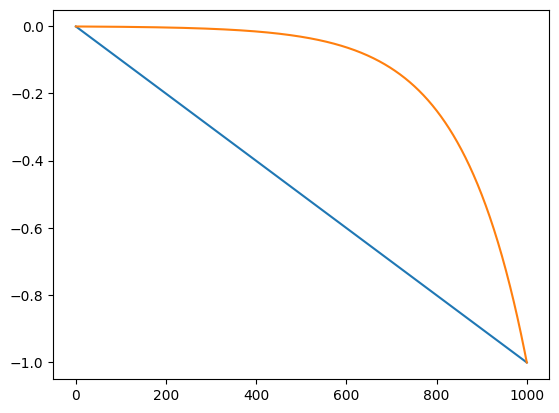

In [132]:
torch.linspace(-0.001,-1, 1000)

plt.plot(torch.linspace(0, 1000, 1000), torch.linspace(-0.001, -1, 1000))
plt.plot(torch.linspace(0, 1000, 1000), -10**torch.linspace(-3, 0, 1000))
plt.show()

So here we are testing the smaller values with more detail, but going faster when they get bigger.

In [140]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Let's try again with this, and track stats:

In [146]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

3481

In [142]:
lri = []
lossi = []

for i in range(1000):

    #mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lri.append(lrs[i])
    lossi.append(loss.item())

    # update the parameters
    for p in parameters:
        p.data -= lrs[i] * p.grad

20.623268127441406
20.05193519592285
18.842763900756836
21.35638999938965
17.624897003173828
20.177988052368164
18.71864128112793
17.932708740234375
19.13005256652832
22.393009185791016
21.125240325927734
19.11414337158203
17.35572052001953
18.665311813354492
20.295862197875977
17.384498596191406
19.128555297851562
16.66752052307129
19.802520751953125
19.12799644470215
18.35158920288086
18.449968338012695
19.205398559570312
19.777353286743164
16.701217651367188
18.888669967651367
18.31168556213379
20.5377140045166
17.6085205078125
18.1562442779541
20.66779136657715
16.95655632019043
17.18682861328125
19.156890869140625
18.765819549560547
18.33201789855957
19.162479400634766
16.386653900146484
18.93893051147461
17.37042236328125
18.4243221282959
18.44793701171875
20.916519165039062
16.5440731048584
18.774227142333984
15.966439247131348
14.05283260345459
14.80867862701416
16.375900268554688
17.270221710205078
21.50428009033203
19.268901824951172
14.954543113708496
16.850744247436523
16.8

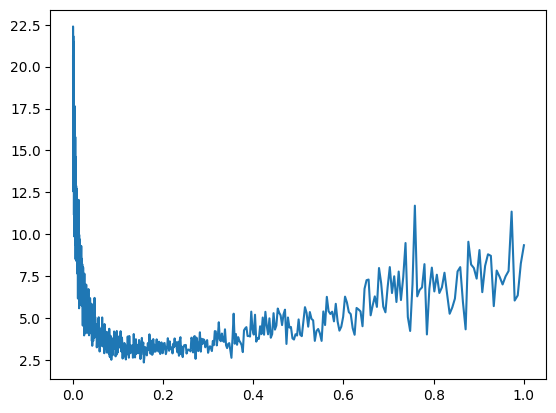

In [144]:
plt.plot(lri, lossi)

We will usually have this kind of graph, so as we can see here, the best learning rate we can set is around 0.1 or 0.2

But let's see actually the exponent of the LRS:

In [147]:
lri = []
lossi = []

for i in range(1000):

    #mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lri.append(lre[i])
    lossi.append(loss.item())

    # update the parameters
    for p in parameters:
        p.data -= lrs[i] * p.grad

19.157001495361328
18.131784439086914
21.599609375
20.937376022338867
20.314075469970703
18.591264724731445
22.32099151611328
19.380613327026367
19.548442840576172
16.857824325561523
18.159690856933594
18.733617782592773
19.178861618041992
17.890575408935547
18.4553165435791
18.563222885131836
18.975034713745117
17.769245147705078
18.757192611694336
16.846525192260742
19.134634017944336
17.59084129333496
18.407087326049805
18.728050231933594
18.310508728027344
19.589250564575195
18.59854507446289
17.87217140197754
18.86060333251953
17.258878707885742
19.470422744750977
18.193286895751953
20.514572143554688
19.689186096191406
19.778154373168945
18.062646865844727
20.259872436523438
18.438047409057617
17.03351402282715
18.772201538085938
16.160606384277344
17.655658721923828
17.69109535217285
17.042665481567383
19.22263526916504
18.11015510559082
19.6452579498291
19.872901916503906
19.290348052978516
18.560400009155273
20.112077713012695
15.110048294067383
19.26549530029297
16.3531379699

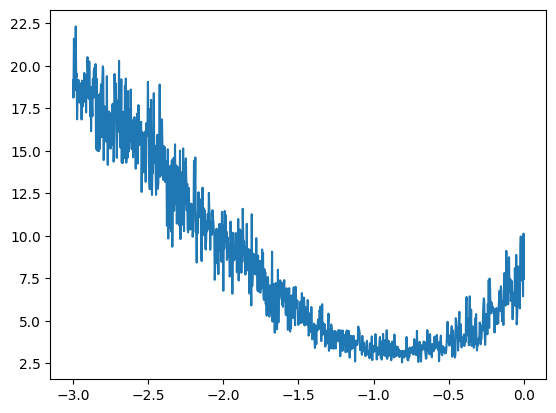

In [148]:
plt.plot(lri, lossi)

Here we can see more clearly how -1 as the exponent is the best exponent, so $10^{-1} = 0.1$. $0.1$ is our best learning rate, the one we used before. 

Let's see how low we can go.

In [150]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

3481

We can do a learning decay of 10x less to make the learning more precise.

In [167]:
for i in range(10000):

    #mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    # update the parameters
    for p in parameters:
        p.data -= 0.01 * p.grad

Evaluating on the whole dataset:

In [168]:
# forward pass
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Y)

tensor(2.3079, grad_fn=<NllLossBackward0>)

## Overfittin and Splitting dataset into train, validation and test

When you scale your model, it gets more capable of adapting and learning perfectly the data it is trained on. 

So the quality of the model actually is measured as how it performs on new data. What people do, is to split the dataset into train 80%, validation (or dev) 10% and test 10% splits.

- Training data is to optimize the parameters to decrease the loss function.
- The validation set is used for development over the hyper-parameters of the model (size of hidden layer, strenght of the regularization, size of the embedding). You cab try a bunch of these configurations to see which works better on this validation split.
- Test split is to evaluate the performance of the model at the end. 

**In practice**, what you actually do is launch a bunch of jobs and wait for them to finish, it can take multiple days and so on. 

In [180]:
def build_dataset(words):

    block_size = 3 # how many chars do we consider for prediction?
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and add new char to context

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [181]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

3481

In [182]:
for i in range(30000):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

In [187]:
# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Ydev)

2.558668613433838


tensor(2.5693, grad_fn=<NllLossBackward0>)

**Note**: When we have similar loss functions in the train and test splits, we usually say that we are underfittin, our model is not powerfull enough to just be purely memorizing the data, our model is very tiny. 

## Scaling the model

A hidden layer of 300 neurons instead of 100.

In [184]:
def build_dataset(words):

    block_size = 3 # how many chars do we consider for prediction?
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and add new char to context

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 300), generator=g, requires_grad=True)
b1 = torch.randn((300), generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

10281

In [195]:
lossi = []
stepsi = []

for i in range(30000):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (48,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.item())
    stepsi.append(i)

    # update the parameters
    for p in parameters:
        p.data -= 0.05 * p.grad

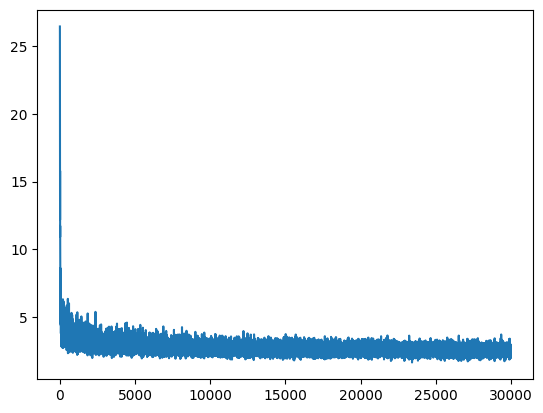

In [186]:
plt.plot(stepsi, lossi)

Noise is caused by the mini batches we are using to train, this can be a signal of bad training, and we could increase the batch size. 

Another bottleneck that maybe our model is having, is that the 2 dimensional space is too low and the neural network can work well in that space. 

In [196]:
# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Ydev)

2.2763776779174805


tensor(2.2989, grad_fn=<NllLossBackward0>)

#### Visualizing the embeddings

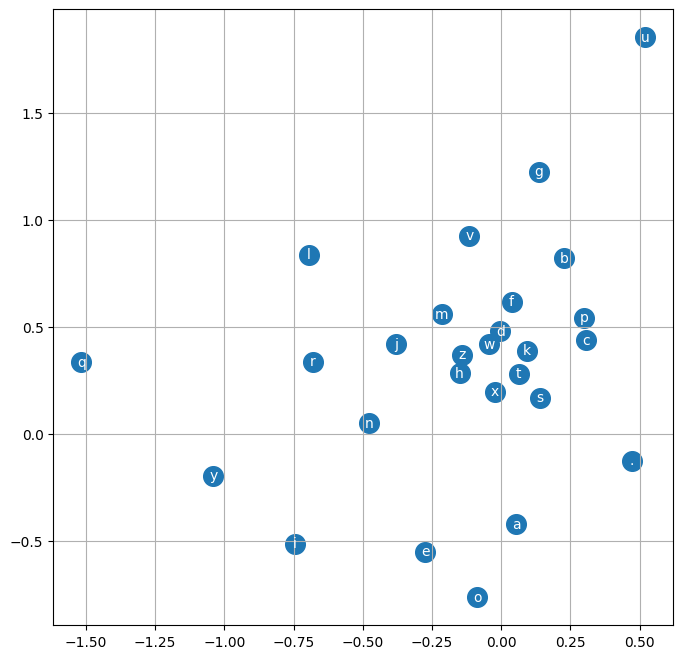

In [197]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

#### Let's use a space of 10 dimensions for the embeddings

In [202]:
def build_dataset(words):

    block_size = 3 # how many chars do we consider for prediction?
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and add new char to context

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn((200), generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

11897

In [203]:
lossi = []
stepsi = []

2.1713712215423584
tensor(2.1989, grad_fn=<NllLossBackward0>)


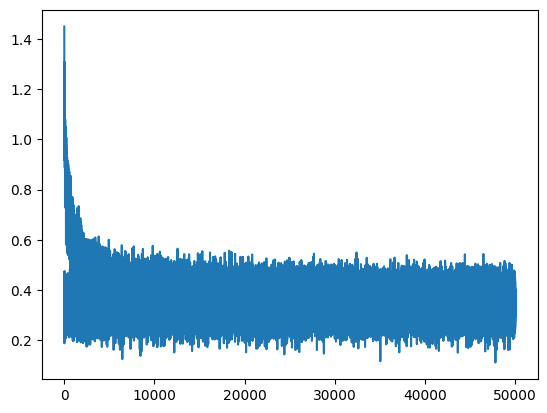

In [206]:


for i in range(50000):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    stepsi.append(i)

    # update the parameters
    for p in parameters:
        p.data -= 0.01 * p.grad

# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev))

plt.plot(stepsi, lossi)

#### Test split

You can only test once on the test split, after doing all the validations on the dev split, and that's the number you can put on your paper and talk about.

#### Let's try to beat 2.17 on the validation split

In [210]:
def build_dataset(words):

    block_size = 3 # how many chars do we consider for prediction?
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and add new char to context

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

def reset():
    global C, W1, b1, W2, b2
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g, requires_grad=True)
    W1 = torch.randn((30, 200), generator=g, requires_grad=True)
    b1 = torch.randn((200), generator=g, requires_grad=True)
    W2 = torch.randn((200, 27), generator=g, requires_grad=True)
    b2 = torch.randn((27), generator=g, requires_grad=True)
    return

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn((200), generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

11897

In [208]:
lossi = []
stepsi = []

2.1063122749328613
tensor(2.1546, grad_fn=<NllLossBackward0>)


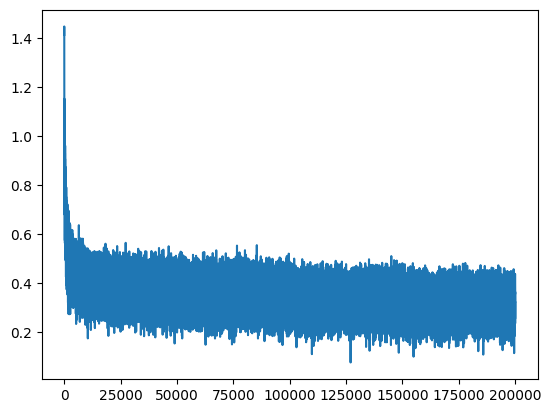

In [209]:


for i in range(200000):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (48,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    stepsi.append(i)

    lr = 0.1 if i < 100000 else 0.05 if i < 150000 else 0.01

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad

# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev))

plt.plot(stepsi, lossi)

In [240]:
embedding_dimension = 10
hidden_dimension = 200
block_size = 3 # how many chars do we consider for prediction?

def build_dataset(words):

    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and add new char to context

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_dimension), generator=g, requires_grad=True)
W1 = torch.randn((embedding_dimension*block_size, hidden_dimension), generator=g, requires_grad=True)
b1 = torch.randn((hidden_dimension), generator=g, requires_grad=True)
W2 = torch.randn((hidden_dimension, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
lossi = []
stepsi = []

11897


2.1025774478912354
2.1550920009613037


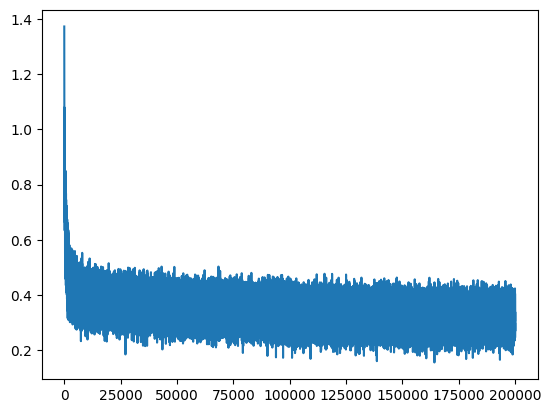

In [241]:
mini_batch_size = 48

for i in range(200000):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    stepsi.append(i)

    lr = 0.1 if i < 100000 else 0.05 if i < 150000 else 0.01

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad

# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev).item())

plt.plot(torch.arange(len(lossi)), lossi)